In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.linear_model import LinearRegression

In [2]:
x0 = np.random.normal(0,1,100000)
x1 = np.random.normal(0,2,100000)

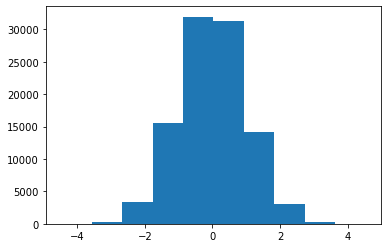

In [52]:
plt.hist(x0);

In [53]:
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import mse, binary_crossentropy
import tensorflow as tf

In [5]:
zero = [0]*100000

In [6]:
X = np.concatenate((np.c_[x0, zero], np.c_[zero, x1]))
np.random.shuffle(X)
print(X)

[[-0.75614621  0.        ]
 [ 0.         -1.36431614]
 [ 0.06971135  0.        ]
 ...
 [ 0.         -3.21096877]
 [ 0.72941324  0.        ]
 [ 1.51784868  0.        ]]


In [56]:
def myloss2d(y_true, y_pred, alpha = 0.0):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - alpha*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2])) \
                - alpha*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))
    return myoutput

In [57]:
#setup the model

myinput_2d = Input(shape=(2,))
encoded_2d = Dense(5, activation='elu')(myinput_2d)
encoded_2d = Dense(5, activation='elu')(encoded_2d)
encoded_2d = Dense(2, activation='linear')(encoded_2d)

encoder_2d = Model(myinput_2d, encoded_2d)
encoder2_2d = encoder_2d(encoder_2d(myinput_2d))
autoencoder_2d = Model(myinput_2d, encoder2_2d)

combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))

myinput_classify_2d = Input(shape=(2,))
myclassifier_2d = Dense(128, activation='elu')(myinput_classify_2d)
myclassifier_2d = Dense(64, activation='elu')(myclassifier_2d)
myclassifier_2d = Dense(1, activation='sigmoid')(myclassifier_2d)
myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)
myclassifier_input_2d = myclassifier_model_2d(myinput_2d)
myclassifier_encoded_2d = myclassifier_model_2d(encoded_2d)

combinedModel_classifier_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d, myclassifier_input_2d, myclassifier_encoded_2d]))

preds = []
preds += [encoder_2d.predict(X)]

for i in range(20):
    print("on i=",i)
    #Now, train the classifier
    encoded_x_2d = encoder_2d.predict(X)
    myclassifier_model_2d.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model_2d.fit(np.concatenate([X,encoded_x_2d]),np.concatenate([np.ones(len(X)),np.zeros(len(X))]), epochs=1, batch_size=int(0.01*len(X)), verbose=0)
        
    #Now, update the autoencoder
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = False

    combinedModel_classifier_2d.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss2d(y_true, y_pred))
    combinedModel_classifier_2d.fit(X,X, epochs=1, batch_size=int(0.01*len(X)), verbose=0)
    
    autoencoder_2d.compile(optimizer='adam', loss='mse')
    autoencoder_2d.fit(X,X, epochs=5, batch_size=int(0.01*len(x0)), verbose=0)
    
    preds += [encoder_2d.predict(X)]
    
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = True

on i= 0
on i= 1
on i= 2
on i= 3
on i= 4
on i= 5
on i= 6
on i= 7
on i= 8
on i= 9
on i= 10
on i= 11
on i= 12
on i= 13
on i= 14
on i= 15
on i= 16
on i= 17
on i= 18
on i= 19


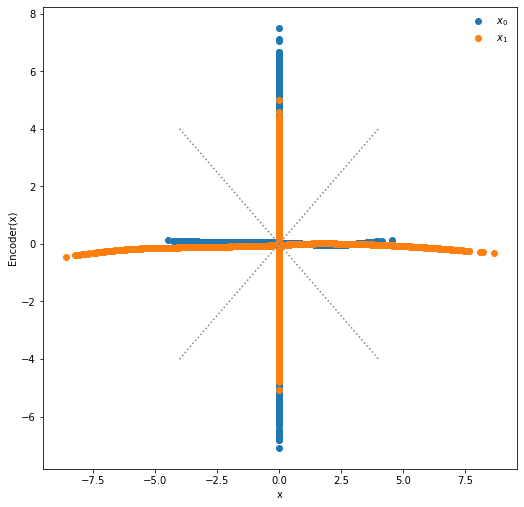

In [74]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],preds[-1][:,0],label="$x_0$")
plt.scatter(X[:,1],preds[-1][:,1],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.plot(np.linspace(-4,4,10),-np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Encoder(x)")
plt.legend(frameon=False)

In [59]:
mypreds = combinedModel_classifier_2d.predict(X)

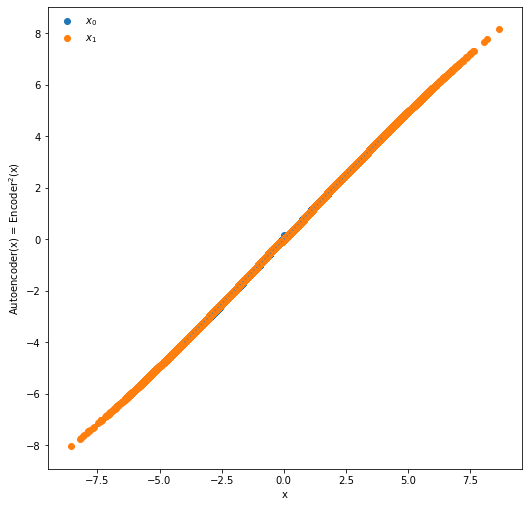

In [60]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],mypreds[:,2],label="$x_0$")
plt.scatter(X[:,1],mypreds[:,3],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Autoencoder(x) = Encoder$^2$(x)")
plt.legend(frameon=False)

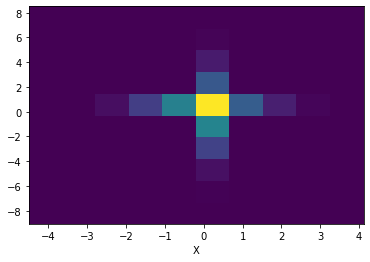

In [7]:
plt.hist2d(X[:,0], X[:,1]);
plt.xlabel("X");

In [62]:
Y = encoder_2d.predict(X)

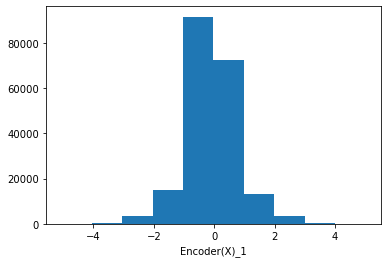

In [69]:
plt.hist(Y[:,1], bins=10);
plt.xlabel("Encoder(X)_1");

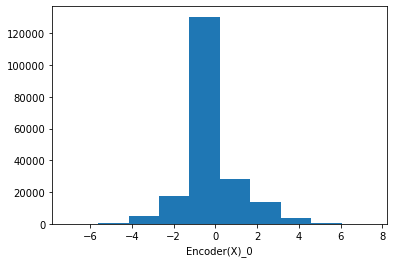

In [70]:
plt.hist(Y[:,0], bins=10);
plt.xlabel("Encoder(X)_0");

In [65]:
np.shape(preds)

(21, 200000, 2)

In [66]:
np.shape(X)

(200000, 2)

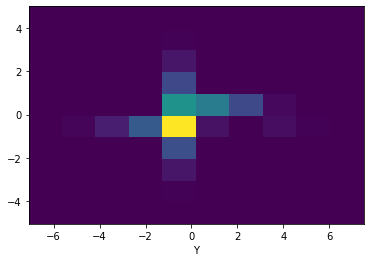

In [67]:
plt.hist2d(Y[:,0], Y[:, 1]);
plt.xlabel("Y");

In [71]:
print(np.shape(X))
print(np.shape(preds[:-1]))
model = LinearRegression().fit(X, preds[-1]);

(200000, 2)
(20, 200000, 2)


In [72]:
print('slope:', model.coef_)
print('intercept:', model.intercept_)

slope: [[-0.02591923  0.88506154]
 [ 1.11963086  0.0185806 ]]
intercept: [ 0.03799631 -0.04246489]
